In [2]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

def conn_matrix_basic(n):
    """Returns nxn symmatric matrix for J with random numbers in [0,1]."""
    J_tri = np.tril(np.random.uniform(0, 1, size=(n, n)), -1)
    J = np.zeros((n,n)) + J_tri + J_tri.T
    return J

def random_spins(n):
    """Returns array of n spins in random configuration of -1 and 1."""
    values = np.random.randint(0, 2, size=n)
    values[values==0] = -1
    return values

def mean_matrix(n, mean):
    J_tri = np.tril(np.random.uniform(mean - 0.1, mean + 0.1, size=(n, n)), -1)
    J = np.zeros((n,n)) + J_tri + J_tri.T
    return J

def energy_diff(spins:np.array, c_matrix):
    """Computes energy difference for flipping one random spin based on J."""
    pos = np.random.randint(0, len(spins))
    delta_E = (spins[pos] * spins * c_matrix[pos]).sum() * 2
    return delta_E, pos


def metropolis(spins, n_iterations, T, c_matrix):
    """Runs one run of the metropolis algorithm with temperature T."""

    magnetisation_list = np.zeros(n_iterations)
    spins_timeseries = np.zeros((n_iterations, len(spins)))

    for i in range(n_iterations):
        diff, spin = energy_diff(spins, c_matrix)

        # accept if new energy is lower
        if diff <= 0:
            spins[spin] *=-1

        # else accept with probability based on Boltzman distribution
        else:
            if np.random.random() < np.exp(-diff/T):
                spins[spin] *=-1

        magnetisation_list[i] = abs(np.mean(spins))
        spins_timeseries[i] = spins

    # discard burn-in period and get mean of magnetization
    magnetisation_list = magnetisation_list[1000:]
    avg_magnetisation = np.mean(magnetisation_list) 
    spins_timeseries = spins_timeseries[1000:]
    
    # calculate susceptibility
    mean_of_squared = np.mean(magnetisation_list**2)
    susceptibility = (mean_of_squared - avg_magnetisation**2)/T

    return spins, avg_magnetisation, susceptibility, spins_timeseries

def multi_metropolis(n_simulations, n_iterations, T, n, c_matrix):
    """Runs n_simulations runs of the metropolis algorithm."""

    list_avg_magnetisation = np.zeros(n_simulations)
    list_sus = np.zeros(n_simulations)
    

    for i in range(n_simulations):

        # start with random spin config and J
        spins = random_spins(n)
        # c_matrix = conn_matrix_basic(n)

        # run metropolis
        _, list_avg_magnetisation[i], list_sus[i], spins_timeseries = metropolis(spins, n_iterations, T, c_matrix) 

    mean_magnet = np.mean(list_avg_magnetisation)
    std_magnet = np.std(list_avg_magnetisation)
    
    mean_sus = np.mean(list_sus)
    std_sus = np.std(list_sus)
    
    return mean_magnet, std_magnet, mean_sus, std_sus
    

def run_simulation(n_simulations:int, n_iterations:int, T_list:np.array, n:int, c_matrix=np.array):
    """Runs metropolis simulations for every temperature in a list of temperatures."""
    n_temp = len(T_list)

    means_mag = np.zeros(n_temp)
    stds_mag = np.zeros(n_temp)
    means_sus = np.zeros(n_temp)
    stds_sus = np.zeros(n_temp)
    for i, T in enumerate(T_list):
        means_mag[i], stds_mag[i], means_sus[i], stds_sus[i] = multi_metropolis(n_simulations, n_iterations, T, n, c_matrix)

    return [means_mag, stds_mag, means_sus, stds_sus]

# @njit
# def count_function(combo, coordinate, spins_timeseries, t, probabilities):
#     """Counts the number of times a spin combination occurs in a timeseries of spin configurations.
#     """
#     [s_j, S_j, S_i] = combo
#     [i,j] = coordinate
#     [pSj, psj_Sj, pSj_Si, psj_Sj_Si] = probabilities

#     if spins_timeseries[t-1][j] == S_j:
#         pSj += 1

#         if spins_timeseries[t-1][i] == S_i:
#             pSj_Si += 1

#         if spins_timeseries[t][j] == s_j:
#             psj_Sj += 1

#             if spins_timeseries[t-1][i] == S_i:
#                 psj_Sj_Si += 1
        
#     return [pSj, psj_Sj, pSj_Si, psj_Sj_Si]

def conn_matrix_not_so_basic(n, fraction_of_zeros):
    """Returns nxn symmatric matrix for J with random numbers in [0,1]."""
    J_tri = np.tril(np.random.uniform(0, 1, size=(n, n)), -1)
    J = np.zeros((n,n)) + J_tri + J_tri.T

    f = int(np.floor(fraction_of_zeros*n*(n-1)/2))
    removed = []
    for i in range(f):
        while True:
            row = np.random.randint(0, n-1)
            cols = [num for num in range(0, n) if num != row]  # to not include central diagonal
            col = np.random.choice(cols)
            entry = [row, col]
            entry_T = [col, row]

            if entry in removed or entry_T in removed:
                continue
        
            J[row][col] = 0
            J[col][row] = 0

            removed.append(entry)
            break
    return J

# @njit
# def get_probability(coordinate, spins_timeseries, combos):
#     """Calculates the probability of all possible spin combinations based on a timeseries of spin configurations."""
#     count_array = np.zeros((8, 4))

#     for t in range(1, len(spins_timeseries)):
#         for k, combo in enumerate(combos):
#             count_array[k] = count_function(combo, coordinate, spins_timeseries, t, count_array[k])

#     return count_array


def get_probability(coordinate, spins_timeseries):
    """Computes counts for each combination of values in timeseries."""

    # get coordinates
    i,j = coordinate

    # get "current" spin orientations for j
    s_j = spins_timeseries[1:, j]

    # get "past" spin orientations for i and j
    S_j = spins_timeseries[:-1, j]
    S_i = spins_timeseries[:-1, i]

    count_array = np.zeros((8,4))

    # compute pSj, psj_Sj, pSj_Si, psj_Sj_Si for all 8 combinations
    i = 0
    for j_1 in [-1,1]:
        pSj = (S_j==j_1).sum()
        for j_0 in [-1,1]:
            psj_Sj = ((s_j==j_0) & (S_j==j_1)).sum()
            for i_1 in [-1,1]:
                pSj_Si = ((S_i==i_1) & (S_j==j_1)).sum()
                psj_Sj_Si = ((s_j==j_0) & (S_j==j_1) & (S_i==i_1)).sum()
                count_array[i] = np.array([pSj, psj_Sj, pSj_Si, psj_Sj_Si])
                i += 1

    return count_array


def TE(spins_timeseries, c_matrix):
    """Computes transfer entropy for a Metropolis timeseries."""

    c_total = 0

    # loop through all nonzero connections
    for coordinate in np.stack(c_matrix.nonzero(), axis=1):

        # get counts for all 8 possible combinations
        count_array = get_probability(coordinate, spins_timeseries)

        # remove any row with a zero value
        count_array = count_array[(count_array[:,3] != 0) & (count_array[:,2] != 0) & (count_array[:,1] != 0) & (count_array[:,0] != 0)]
        
        # convert to probabilities
        prob = (count_array / (spins_timeseries.shape[0]-1)).T

        # compute Cij
        c = np.sum(prob[3] * np.log((prob[1] * prob[2]) / (prob[3] * prob[0])))
        c_total += c

    return c_total

def plot_results(sim_data, T_list, sim_name, save=False):
    """Plots the results of a full simulation."""
    means_mag, stds_mag, means_sus, stds_sus = sim_data
    lower_bound = np.subtract(means_mag, stds_mag)
    upper_bound = np.add(means_mag, stds_mag)
    plt.plot(T_list, means_mag)
    plt.fill_between(T_list, lower_bound, upper_bound, alpha=0.3)
    plt.xlabel('T')
    plt.ylabel('M')
    plt.grid()

    if save:
        plt.savefig(f'{sim_name}_M.png', bbox_inches='tight')
    plt.show()    
    
    lower_bound = np.subtract(means_sus, stds_sus)
    upper_bound = np.add(means_sus, stds_sus)
    plt.plot(T_list, means_sus)
    plt.fill_between(T_list, lower_bound, upper_bound, alpha=0.3)
    plt.xlabel('T')
    plt.ylabel('Susceptibility')
    plt.grid()
    idx = np.argmax(sim_data[2])
    plt.vlines(T_list[idx],  min(sim_data[2]), max(sim_data[2])*1.2, linestyles='dashed', color = 'r')

    if save:
        plt.savefig(f'{sim_name}_sus.png', bbox_inches='tight')
    plt.show()


In [3]:
matrix = mean_matrix(10, 0.5)
matrix.mean()

0.4364593959736792

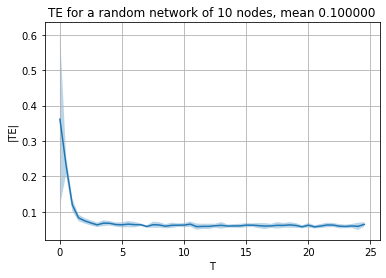

C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


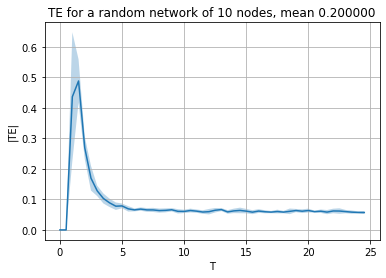

C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


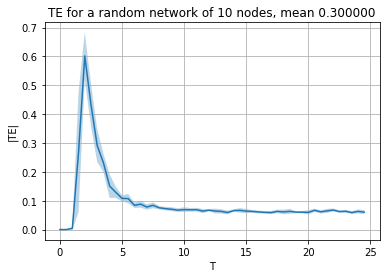

C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


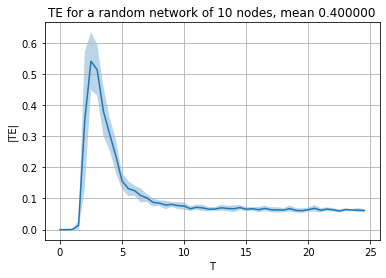

C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


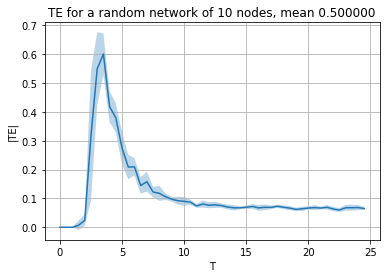

C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


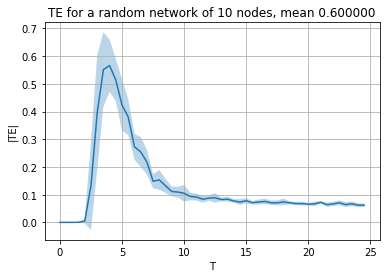

C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


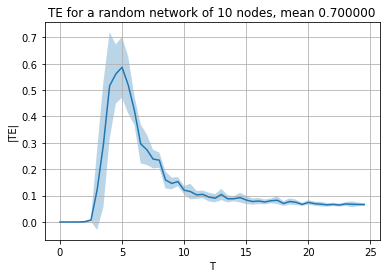

C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


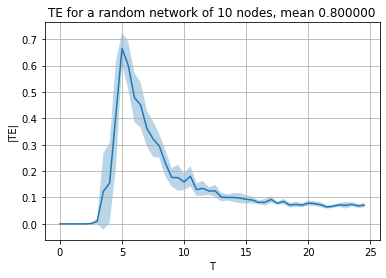

C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_13340\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


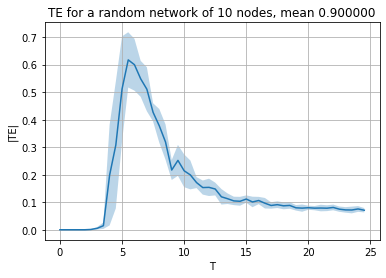

In [6]:
import itertools
runs = 10
combos = list(itertools.product([-1, 1], repeat=3))
C = []
C_std = []
temperatures = np.linspace(0.5, 25, 50)
mean_list = np.arange(0.1, 1, 0.1)
n_list = [5, 10, 25, 50]
for mean in mean_list:
    n = 10
    J = mean_matrix(n, mean)
    C= []
    C_std = []
    for T in temperatures:
        x = np.zeros(runs)
        for i in range(0, runs):
            spins = random_spins(n)        
            _, list_avg_magnetisation, list_sus, spins_timeseries = metropolis(spins,2500, T, J) 
            x[i] = TE(spins_timeseries, J)
        C_std.append(np.std(x))
        C.append(np.abs(np.mean(x)))
    temperatures = np.arange(0, 25, 0.5)
    lower_bound = np.subtract(C, C_std)
    upper_bound = np.add(C, C_std)
    plt.plot(temperatures, C)
    plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)

    plt.ylabel('|TE|')
    plt.xlabel('T')
    plt.grid()
    plt.title('TE for a random network of 10 nodes, mean %f' %mean)
    plt.savefig('10_nodes_TE.png', bbox_inches='tight')
    plt.show()

C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


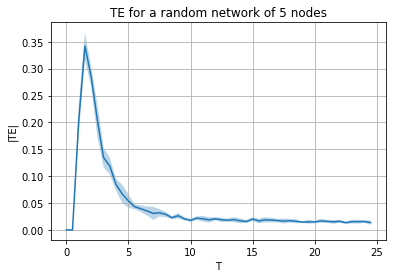

C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


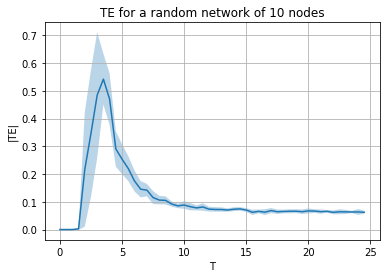

C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


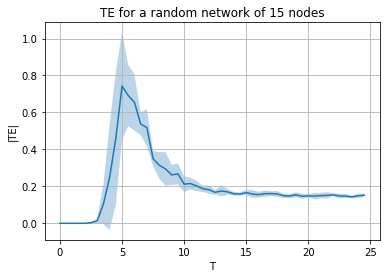

C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


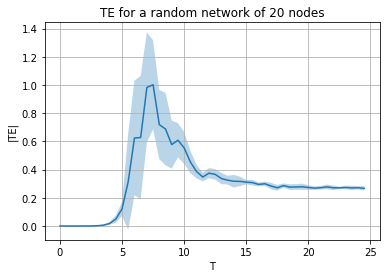

C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  if np.random.random() < np.exp(-diff/T):
C:\Users\87395\AppData\Local\Temp\ipykernel_7888\82715526.py:57: RuntimeWarning: invalid value encountered in double_scalars
  susceptibility = (mean_of_squared - avg_magnetisation**2)/T


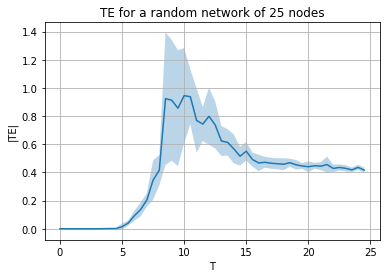

In [64]:
n_list = [5, 10, 15, 20, 25]
for n in n_list:
    mean = 0.5
    J = mean_matrix(n, mean)
    C= []
    C_std = []
    for T in temperatures:
        x = np.zeros(runs)
        for i in range(0, runs):
            spins = random_spins(n)        
            _, list_avg_magnetisation, list_sus, spins_timeseries = metropolis(spins,2500, T, J) 
            x[i] = TE(spins_timeseries, J)
        C_std.append(np.std(x))
        C.append(np.abs(np.mean(x)))
    temperatures = np.arange(0, 25, 0.5)
    lower_bound = np.subtract(C, C_std)
    upper_bound = np.add(C, C_std)
    plt.plot(temperatures, C)
    plt.fill_between(temperatures, lower_bound, upper_bound, alpha=0.3)

    plt.ylabel('|TE|')
    plt.xlabel('T')
    plt.grid()
    plt.title('TE for a random network of %d nodes' %n)
    plt.savefig('10_nodes_TE.png', bbox_inches='tight')
    plt.show()